## Import Libraries

In [48]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from scipy.spatial.distance import cosine


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


from PIL import Image, ImageEnhance

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## Load Data

In [49]:
data = np.load("/kaggle/input/dataset1/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## Inspect Data

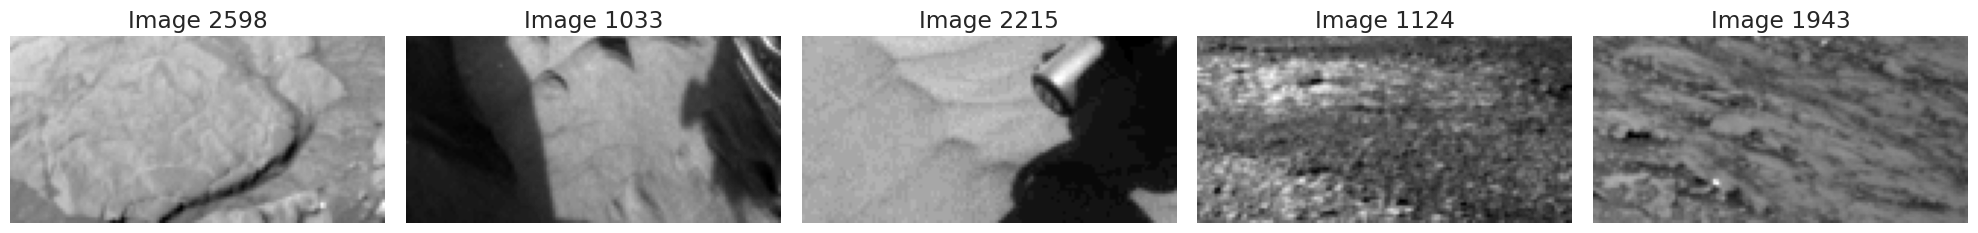

In [50]:
# Plot the randomly selected images
num_samples = 5
random_indices = np.random.choice(len(X_train), num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i, ax in enumerate(axes):
    index = random_indices[i]
    ax.imshow(X_train[index], cmap='gray')  # Display the image in grayscale
    ax.axis('off')  # Hide axis
    ax.set_title(f"Image {index}")

plt.tight_layout()
plt.show()

### Manual selection of noise images


In [51]:
noise_indices = [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, \
                536, 552, 669, 675, 741, 744, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, \
                1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, \
                1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, \
                1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, \
                2365, 2372, 2414, 2453, 2522, 2535]

print(f"Found {len(noise_indices)} contamination images")

Found 106 contamination images


### Split data into cleaned data and noise

In [52]:
def split_data(X, y, noise_indices):
    # Convert noise_indices to a set for faster lookup
    noise_indices_set = set(noise_indices)

    # Split into cleaned and contamination based on noise_indices
    contamination_X = X[noise_indices]
    contamination_y = y[noise_indices]
    
    # Get all indices that are not in noise_indices (cleaned data)
    cleaned_indices = [i for i in range(len(X)) if i not in noise_indices_set]

    # Cleaned data
    cleaned_X = X[cleaned_indices]
    cleaned_y = y[cleaned_indices]

    return cleaned_X, cleaned_y, contamination_X, contamination_y

cleaned_X, cleaned_y, contamination_X, contamination_y = split_data(X_train, y_train, noise_indices)

# To check the results
print(f"Cleaned data shape: {cleaned_X.shape}")
print(f"Contamination data shape: {contamination_X.shape}")


Cleaned data shape: (2509, 64, 128)
Contamination data shape: (106, 64, 128)


### Inspect a slice of cleaned data

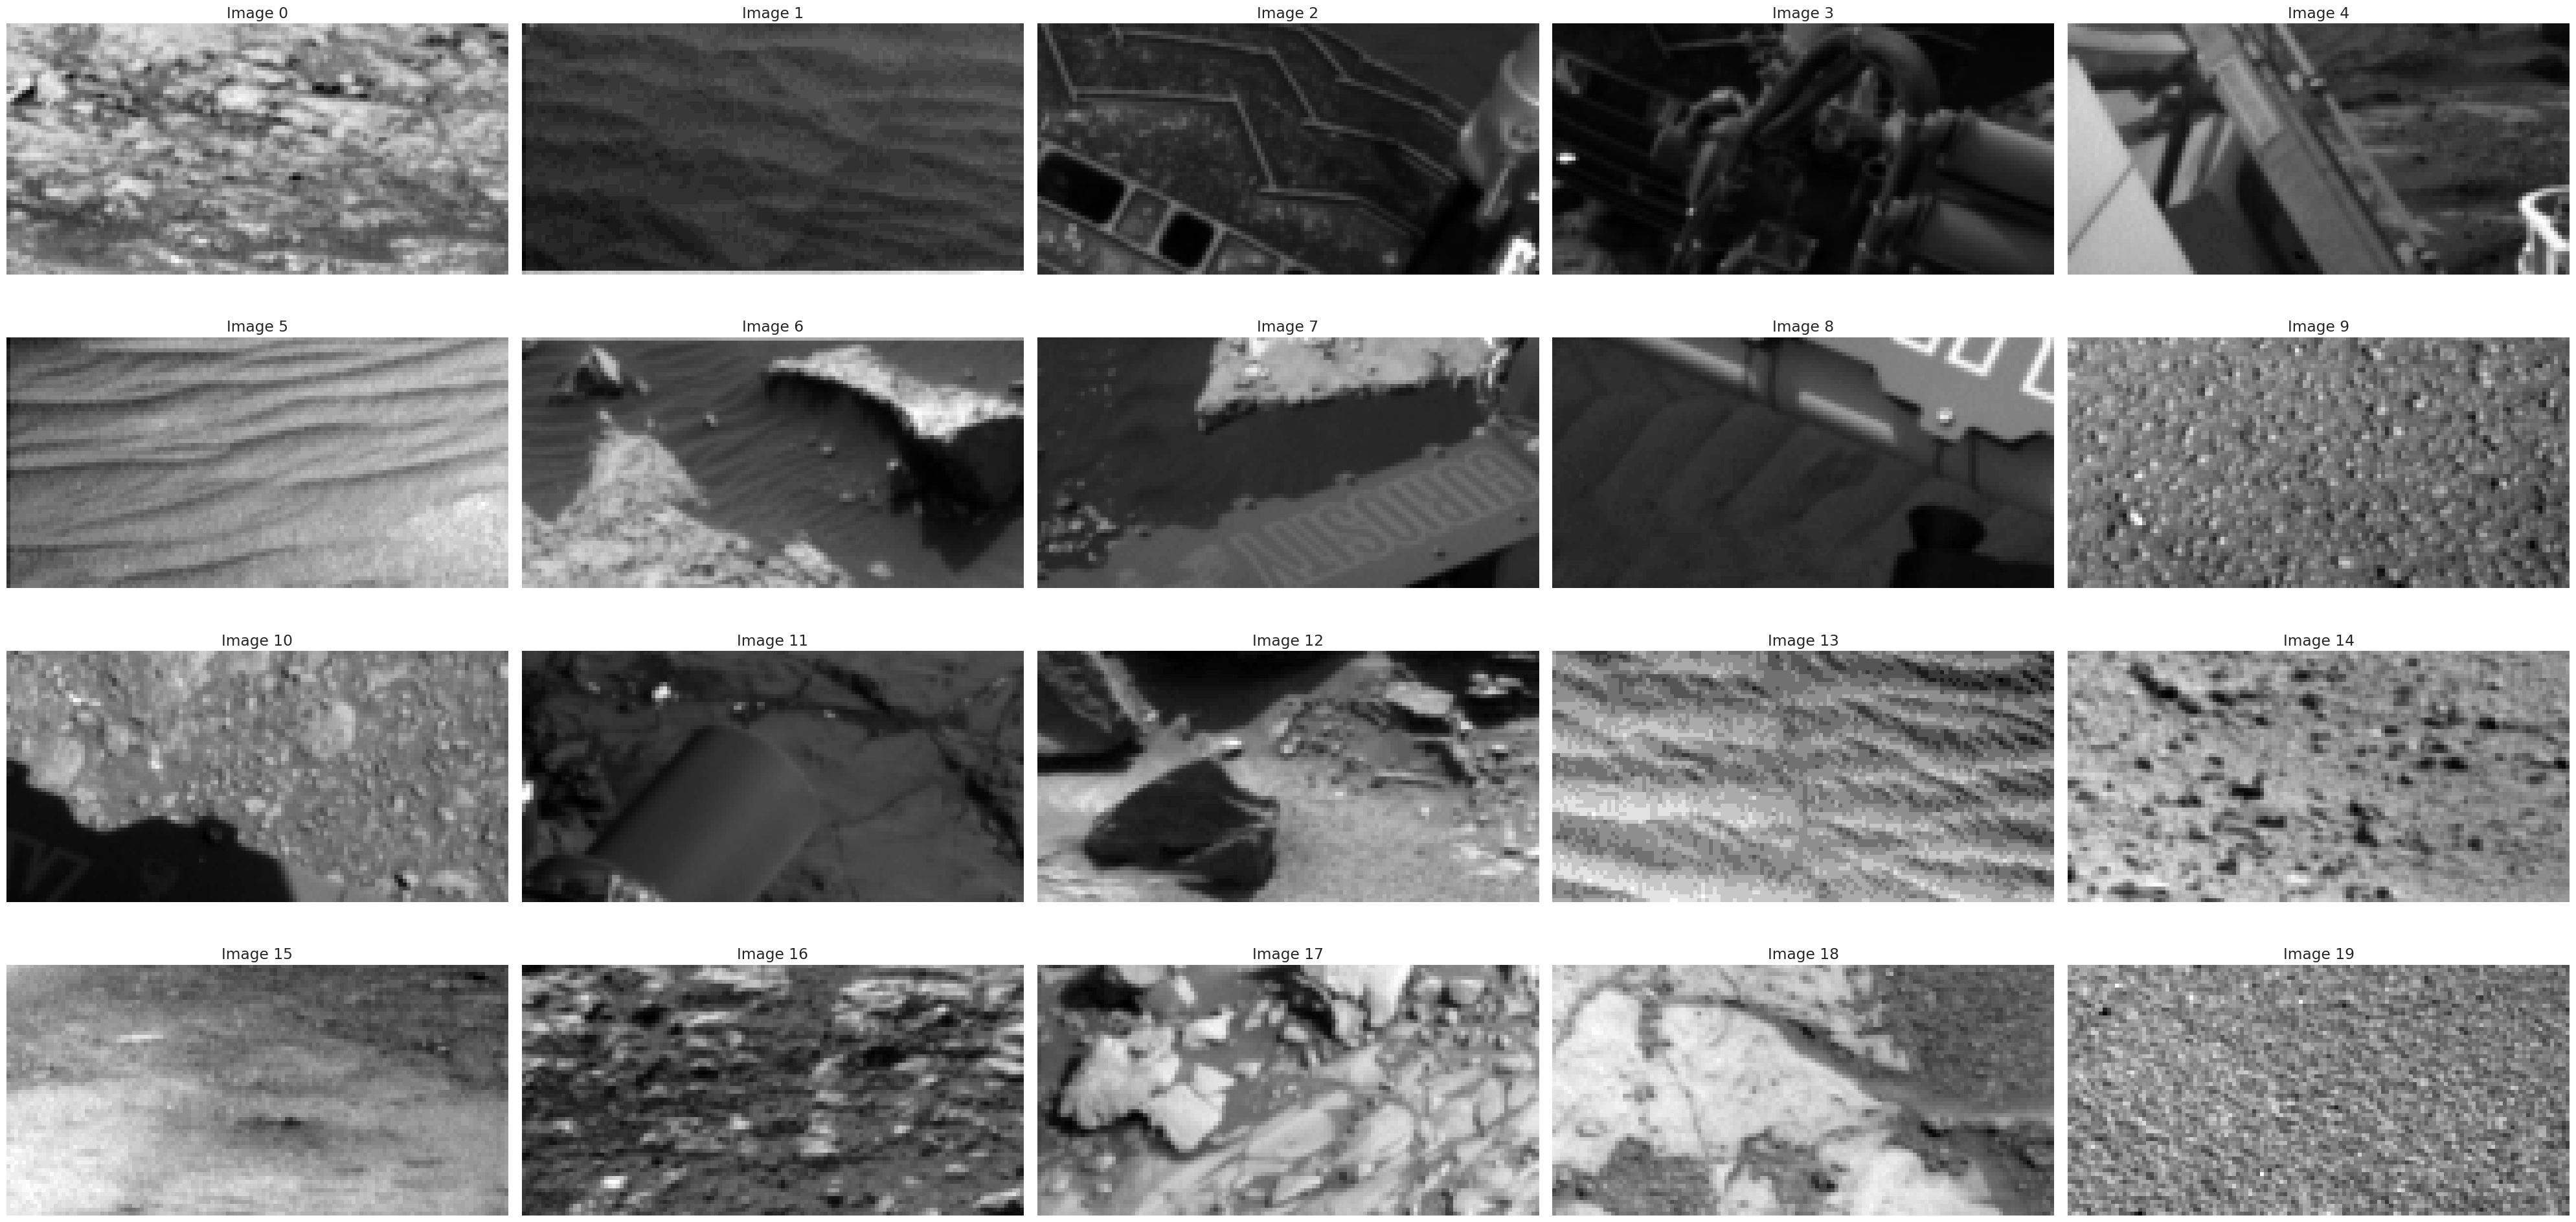

In [53]:
# Parameters for layout
X_train_cleaned_selected = cleaned_X[:20]
images_per_row = 5  # Number of images per row
num_images = len(X_train_cleaned_selected)  # Total number of images
num_rows = math.ceil(num_images / images_per_row)  # Calculate the number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(40, 5 * num_rows))

# Flatten the axes for easier iteration (handles cases where `axes` is 2D)
axes = axes.ravel()

# Plot all the contamination images
for i, ax in enumerate(axes):
    if i < num_images:
        ax.imshow(X_train_cleaned_selected[i], cmap='gray')  # Display the image in grayscale
        ax.axis('off')  # Hide axis
        ax.set_title(f"Image {i}")
    else:
        ax.axis('off')  # Hide any unused subplot axes

plt.tight_layout()
plt.show()

### Inspect all of the noise images

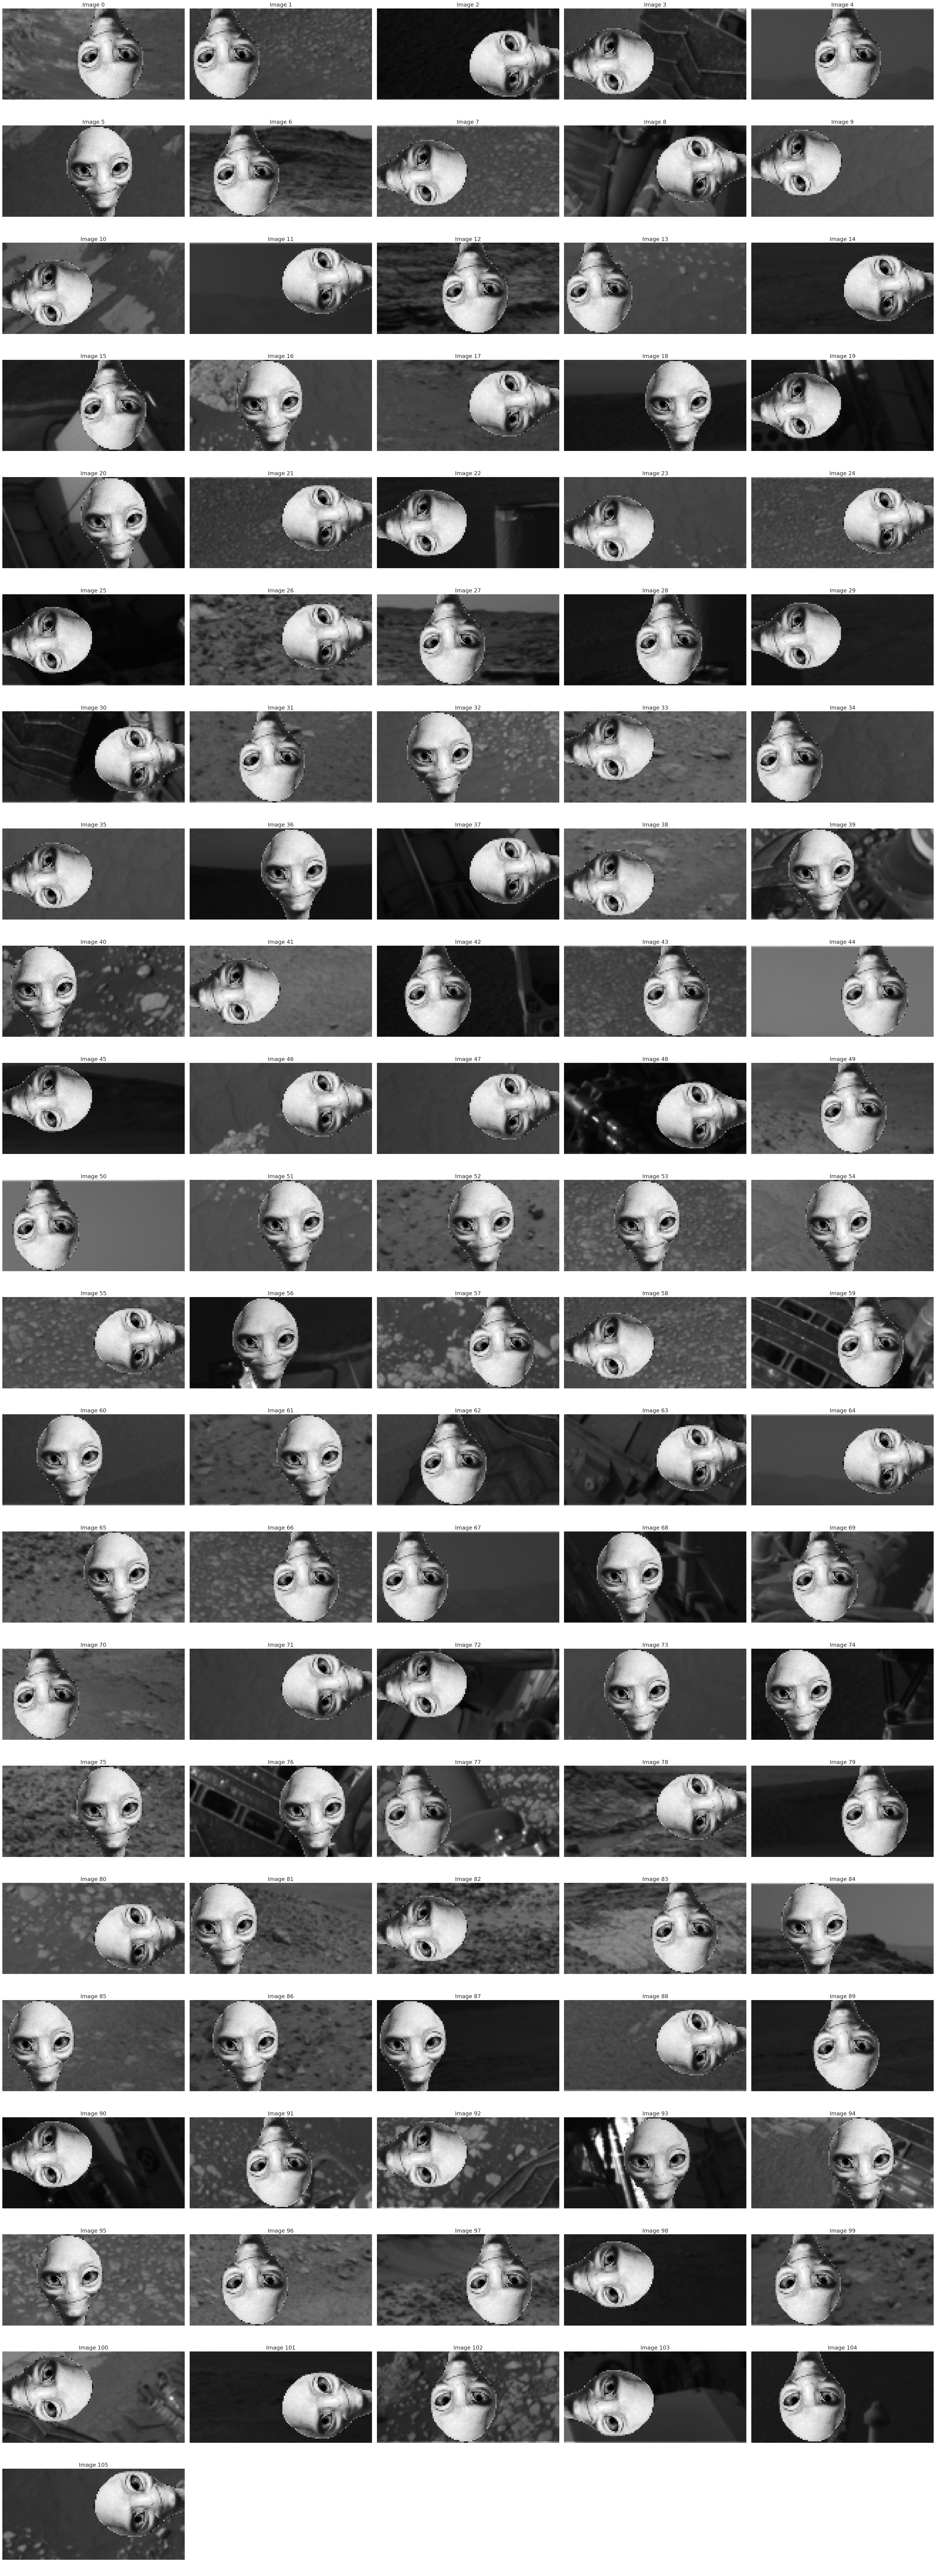

In [54]:
# Parameters for layout
images_per_row = 5  # Number of images per row
num_images = len(contamination_X)  # Total number of images
num_rows = math.ceil(num_images / images_per_row)  # Calculate the number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(40, 5 * num_rows))

# Flatten the axes for easier iteration (handles cases where `axes` is 2D)
axes = axes.ravel()

# Plot all the contamination images
for i, ax in enumerate(axes):
    if i < num_images:
        ax.imshow(contamination_X[i], cmap='gray')  # Display the image in grayscale
        ax.axis('off')  # Hide axis
        ax.set_title(f"Image {i}")
    else:
        ax.axis('off')  # Hide any unused subplot axes

plt.tight_layout()
plt.show()

### Looking at cleaned data

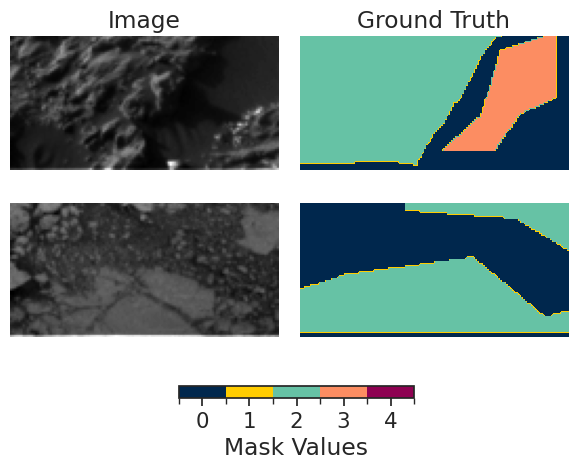

In [55]:
# Define the unique classes in the mask
classes = [0, 1, 2, 3, 4]  # Replace with the actual values in cleaned_y

# Define a custom colormap using the new colors
cmap = mcolors.ListedColormap(["#00274d", "#ffcc00", "#66c2a5", "#fc8d62", "#8e0152"])
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(classes) + 1) - 0.5, ncolors=len(classes))

plt.figure(figsize=(6, 4))

random_index1 = 1609
random_index2 = 2005

# Plot first image
plt.subplot(2, 2, 1)
plt.imshow(cleaned_X[random_index1], cmap="gray")
plt.axis("off")
plt.title("Image")

plt.subplot(2, 2, 2)
im = plt.imshow(cleaned_y[random_index1], cmap=cmap, norm=norm)
plt.title("Ground Truth")
plt.axis("off")

# Plot second image
plt.subplot(2, 2, 3)
plt.imshow(cleaned_X[random_index2], cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(cleaned_y[random_index2], cmap=cmap, norm=norm)
plt.axis("off")

# Adjust layout to make room for the colorbar
plt.subplots_adjust(bottom=-0.1)  # Adjust to move colorbar lower

# Add colorbar with smaller size
cbar = plt.colorbar(im, ax=plt.gcf().axes, orientation='horizontal', fraction=0.03, pad=0.1)
cbar.set_ticks(classes)
cbar.set_label("Mask Values")

# Display the images
plt.tight_layout()
plt.show()


### Define Model Parameters

In [56]:
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4,  # big rock
}

# Set batch size for training
BATCH_SIZE = 16

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 100

# Set maximum number of training epochs
EPOCHS = 500

NUM_CLASSES = len(set(category_map.values()))
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


### Split into training and validation

In [57]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(
    cleaned_X, cleaned_y, test_size=0.2, random_state=42
)

# Print the shapes to confirm the split
print(f"Training set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Validation set: X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


Training set: X_train shape: (2007, 64, 128), y_train shape: (2007, 64, 128)
Validation set: X_val shape: (502, 64, 128), y_val shape: (502, 64, 128)


In [58]:
# Normalize the data to [0, 1]
X_train = X_train/ 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Check if the data already has the channel dimension (i.e., check if the shape has 4 dimensions)
if X_train.ndim == 3:  # (batch_size, height, width)
    # Add the channel dimension if missing
    X_train = np.expand_dims(X_train, axis=-1)  # Adds the channel dimension
    X_val = np.expand_dims(X_val, axis=-1)  # Same for validation data

# Check the shapes to make sure they are correct
print(f"X_train shape: {X_train.shape}")  # Should be (batch_size, 64, 128, 1)
print(f"X_val shape: {X_val.shape}")  # Same for validation


X_train shape: (2007, 64, 128, 1)
X_val shape: (502, 64, 128, 1)


In [59]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

# Check the shape of the dataset to ensure it's batched correctly
for images, labels in train_dataset.take(1):
    print(f"Batch shape: {images.shape}")  # Should be (batch_size, 64, 128, 1)


Batch shape: (32, 64, 128, 1)


In [60]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
        
    flip_prob = tf.random.uniform([], seed=seed)
    if flip_prob > 0.5:
        image = tf.image.flip_up_down(image)
        label = tf.image.flip_left_right(label)
    else:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_up_down(label)
    return image, label

def augmentation(image, label, seed=None):
    # Use preprocessing layers for data augmentation
    return random_flip(image, label, seed)

In [61]:
train_dataset2 = train_dataset.map(augmentation)
train_dataset_aug = train_dataset.concatenate(train_dataset2)
for images, labels in train_dataset.take(1):
    print(f"Batch shape: {images.shape}")  # Should be (batch_size, 64, 128, 1)

Batch shape: (32, 64, 128, 1)


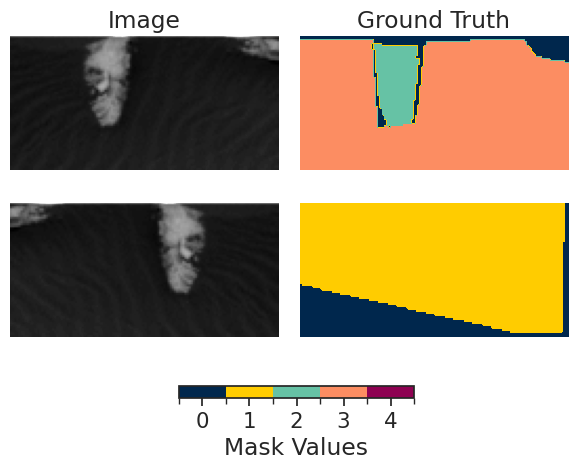

In [62]:
# Define the unique classes in the mask
classes = [0, 1, 2, 3, 4]  # Replace with the actual values in y_train

# Define a custom colormap using the new colors
cmap = mcolors.ListedColormap(["#00274d", "#ffcc00", "#66c2a5", "#fc8d62", "#8e0152"])
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(classes) + 1) - 0.5, ncolors=len(classes))

plt.figure(figsize=(6, 4))

index = 1

# Get one batch from the dataset
for image_batch, label_batch in train_dataset.take(1):  # Take a single batch
    # Convert tensors to numpy arrays for plotting
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()

    # Plot first image and label
    plt.subplot(2, 2, 1)
    plt.imshow(image_batch[index], cmap="gray")
    plt.axis("off")
    plt.title("Image")

    plt.subplot(2, 2, 2)
    im = plt.imshow(label_batch[index], cmap=cmap, norm=norm)
    plt.title("Ground Truth")
    plt.axis("off")

for image_batch, label_batch in train_dataset2.take(1):  # Take a single batch
    # Convert tensors to numpy arrays for plotting
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()
    # Plot second image and label
    plt.subplot(2, 2, 3)
    plt.imshow(image_batch[index], cmap="gray")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(label_batch[index], cmap=cmap, norm=norm)
    plt.axis("off")

        # Adjust layout to make room for the colorbar
    plt.subplots_adjust(bottom=-0.1)  # Adjust to move colorbar lower

        # Add colorbar with smaller size
    cbar = plt.colorbar(im, ax=plt.gcf().axes, orientation='horizontal', fraction=0.03, pad=0.1)
    cbar.set_ticks(classes)
    cbar.set_label("Mask Values")

        # Display the images
    plt.tight_layout()
    plt.show()



## Models

In [63]:
### Simple UNET Model
def multi_unet_model(n_classes=4, IMG_HEIGHT=64, IMG_WIDTH=128, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # inputs = augmentation(inputs)
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same',)(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(NUM_CLASSES, kernel_size=1, padding='same', activation="softmax", name='output_layer')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs], name='UNet')
    
    
    
    return model
 

In [64]:
###Endoer Decoder UNET Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

#Convolutional block to be used in autoencoder and U-Net
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block for autoencoder (no skip connections)
def decoder_block(input, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = conv_block(x, num_filters)
    return x

#Encoder will be the same for Autoencoder and U-net
#We are getting both conv output and maxpool output for convenience.
#we will ignore conv output for Autoencoder. It acts as skip connections for U-Net
def build_encoder(input_image):
    #inputs = Input(input_shape)

    s1, p1 = encoder_block(input_image, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    encoded = conv_block(p4, 1024) #Bridge

    return encoded

#Decoder for Autoencoder ONLY.
def build_decoder(encoded):
    d1 = decoder_block(encoded, 512)
    d2 = decoder_block(d1, 256)
    d3 = decoder_block(d2, 128)
    d4 = decoder_block(d3, 64)

    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(d4)
    return decoded

#Use encoder and decoder blocks to build the autoencoder.
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    autoencoder = Model(input_img, build_decoder(build_encoder(input_img)))
    return(autoencoder)

# model=build_autoencoder((256, 256, 3))
# print(model.summary())

#Decoder block for unet
#skip features gets input from encoder for concatenation
def decoder_block_for_unet(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)
    

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block_for_unet(b1, s4, 512)
    d2 = decoder_block_for_unet(d1, s3, 256)
    d3 = decoder_block_for_unet(d2, s2, 128)
    d4 = decoder_block_for_unet(d3, s1, 64)

    outputs = Conv2D(5, 1, padding="same", activation="softmax")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1     │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_18         │ (None, 64, 128, │       640 │ input_layer_1… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       256 │ conv2d_18[0][… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_19         │ (None, 64, 128, │    36,928 │ activation[0]… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       256 │ conv2d_19[0][… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_1      │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_4   │ (None, 32, 64,  │         0 │ activation_1[… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_20         │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       512 │ conv2d_20[0][… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_2      │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_21         │ (None, 32, 64,  │   147,584 │ activation_2[… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       512 │ conv2d_21[0][… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_3      │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_5   │ (None, 16, 32,  │         0 │ activation_3[… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_22         │ (None, 16, 32,  │   295,168 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 16, 32,  │     1,024 │ conv2d_22[0][… │   Y 

 Total params: 31,054,405 (118.46 MB)

 Trainable params: 31,042,629 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

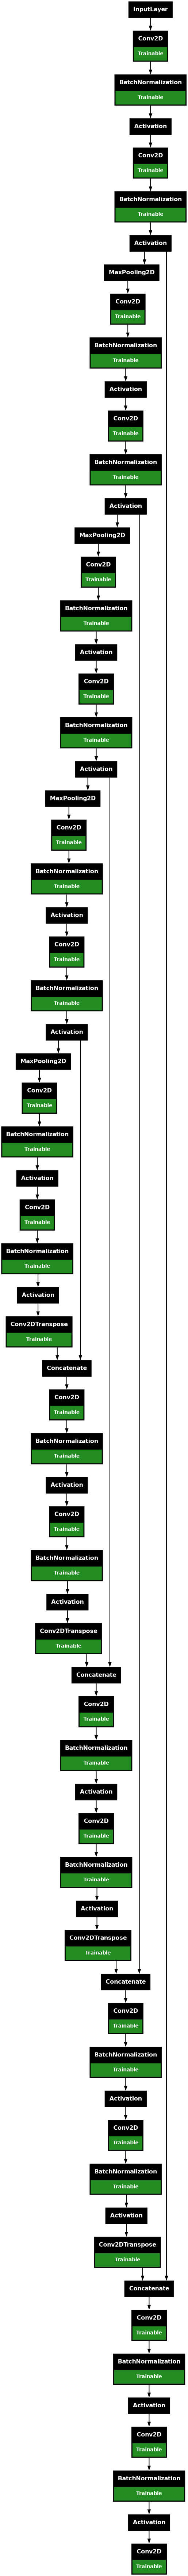

In [65]:
model = build_unet((64,128,1))

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [66]:
def load_single_image(image_path, label_path, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)  # Ensure 3 channels
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label

In [67]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, frequency=10):
        # Pass the full validation dataset and frequency for visualization
        self.val_dataset = val_dataset
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Get one batch from the validation dataset
            for image_batch, label_batch in self.val_dataset.take(1):
                # Choose the first image in the batch for visualization
                image = image_batch[0].numpy()
                label = label_batch[0].numpy()

                # Add the batch dimension to image (model expects a batch of images)
                image = np.expand_dims(image, axis=0)  # Shape (1, 64, 128, 1)

                pred = self.model.predict(image, verbose=0)
                y_pred = tf.math.argmax(pred, axis=-1)
                y_pred = y_pred.numpy()

                # Create colormap
                num_classes = NUM_CLASSES
                # colormap = create_segmentation_colormap(num_classes)

                plt.figure(figsize=(16, 4))

                # Input image
                plt.subplot(1, 3, 1)
                plt.imshow(image.squeeze())
                plt.title("Input Image")
                plt.axis('off')
    
                # Ground truth
                plt.subplot(1, 3, 2)
                # colored_label = apply_colormap(label.squeeze(), colormap)
                plt.imshow(label.squeeze())
                plt.title("Ground Truth Mask")
                plt.axis('off')
    
                # Prediction
                plt.subplot(1, 3, 3)
                # colored_pred = apply_colormap(y_pred.squeeze(), colormap)
                plt.imshow(y_pred.squeeze())
                plt.title("Predicted Mask")
                plt.axis('off')
    
                plt.tight_layout()
                plt.show()
                plt.close()

                plt.show()


In [68]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [69]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

# viz_callback = VizCallback(X_val[0], y_val[0])
viz_callback = VizCallback(val_dataset, frequency=10)

Epoch 1/500


W0000 00:00:1734178422.345418      75 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


 62/126 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.3894 - loss: 1.3922 - mean_iou: 0.1688

W0000 00:00:1734178477.417171      75 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.4041 - loss: 1.3441 - mean_iou: 0.1753

W0000 00:00:1734178526.016557      75 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734178530.321208      76 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


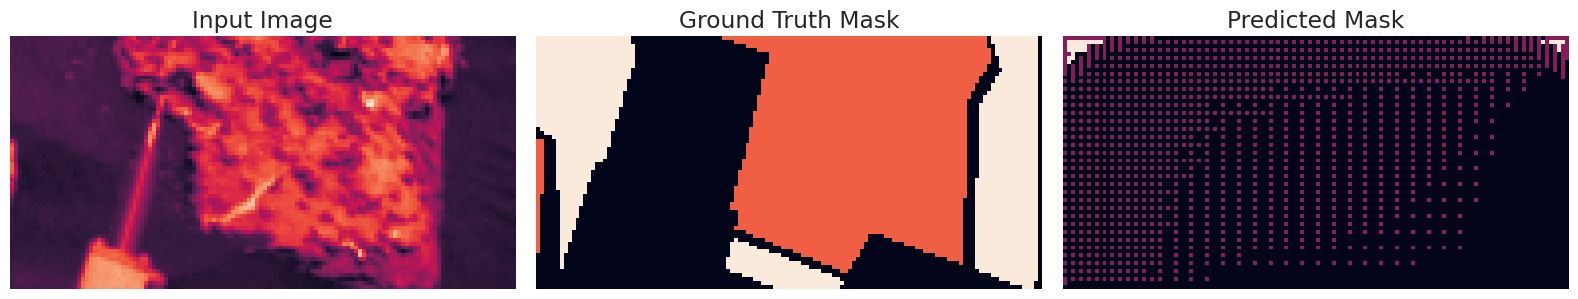

126/126 ━━━━━━━━━━━━━━━━━━━━ 132s 633ms/step - accuracy: 0.4042 - loss: 1.3438 - mean_iou: 0.1753 - val_accuracy: 0.2510 - val_loss: 13.5813 - val_mean_iou: 0.0247
Epoch 2/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - accuracy: 0.4767 - loss: 1.1769 - mean_iou: 0.2173 - val_accuracy: 0.2527 - val_loss: 3.5660 - val_mean_iou: 0.0282
Epoch 3/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.5115 - loss: 1.1313 - mean_iou: 0.2433 - val_accuracy: 0.2326 - val_loss: 1.7703 - val_mean_iou: 0.0972
Epoch 4/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.5578 - loss: 1.0670 - mean_iou: 0.2706 - val_accuracy: 0.4372 - val_loss: 1.2559 - val_mean_iou: 0.1961
Epoch 5/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.5761 - loss: 1.0471 - mean_iou: 0.2905 - val_accuracy: 0.5551 - val_loss: 1.1271 - val_mean_iou: 0.2494
Epoch 6/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 243ms/step - accuracy: 0.6040 - loss: 0.9981 - mean_iou: 0.3170 - val_accuracy: 0.4509 - val_lo

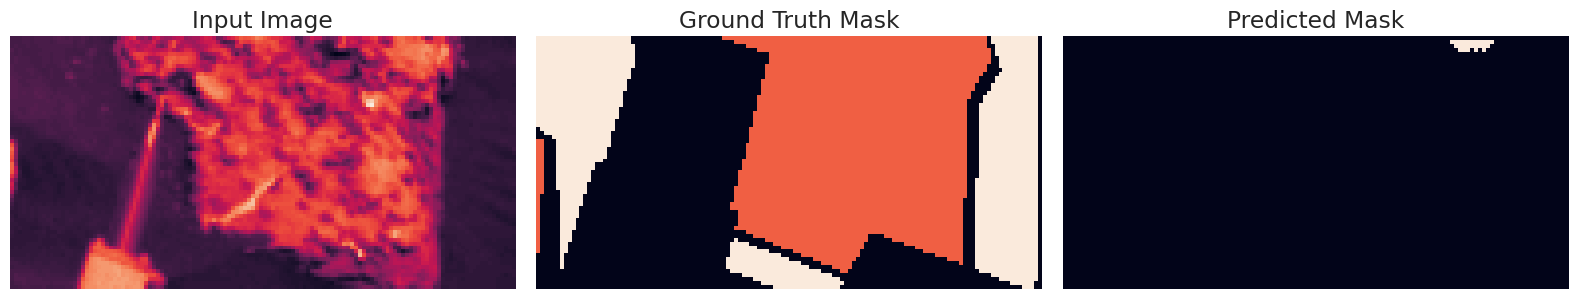

126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 251ms/step - accuracy: 0.6621 - loss: 0.9112 - mean_iou: 0.3708 - val_accuracy: 0.5972 - val_loss: 1.0036 - val_mean_iou: 0.2832
Epoch 12/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.6623 - loss: 0.9075 - mean_iou: 0.3697 - val_accuracy: 0.6361 - val_loss: 1.0049 - val_mean_iou: 0.3302
Epoch 13/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.6694 - loss: 0.9014 - mean_iou: 0.3760 - val_accuracy: 0.6174 - val_loss: 1.0170 - val_mean_iou: 0.3177
Epoch 14/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.6737 - loss: 0.8880 - mean_iou: 0.3805 - val_accuracy: 0.6274 - val_loss: 0.9987 - val_mean_iou: 0.3200
Epoch 15/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.6763 - loss: 0.8869 - mean_iou: 0.3824 - val_accuracy: 0.6338 - val_loss: 0.9516 - val_mean_iou: 0.3223
Epoch 16/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.6834 - loss: 0.8773 - mean_iou: 0.3907 - val_accuracy: 0.6204 - val

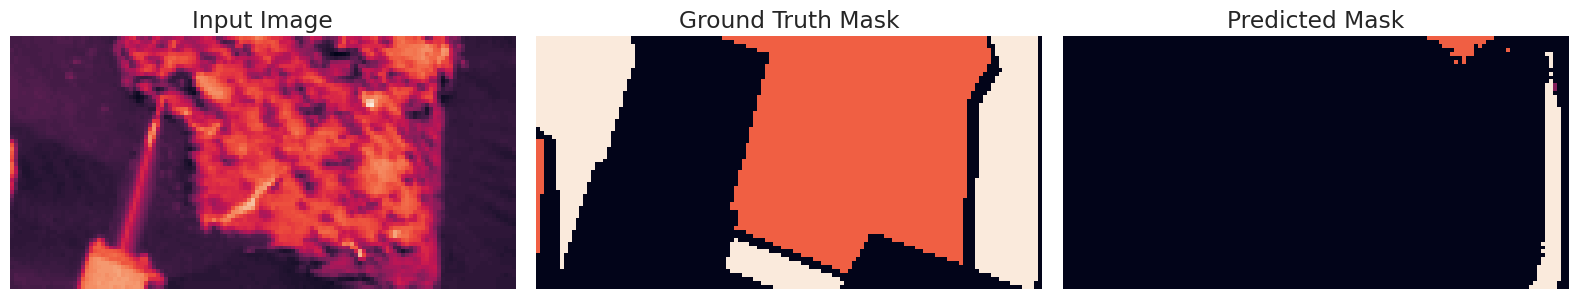

126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 248ms/step - accuracy: 0.6962 - loss: 0.8476 - mean_iou: 0.4039 - val_accuracy: 0.6465 - val_loss: 0.9411 - val_mean_iou: 0.3407
Epoch 22/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.7029 - loss: 0.8366 - mean_iou: 0.4089 - val_accuracy: 0.6525 - val_loss: 0.9305 - val_mean_iou: 0.3507
Epoch 23/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.7036 - loss: 0.8294 - mean_iou: 0.4119 - val_accuracy: 0.6622 - val_loss: 0.9526 - val_mean_iou: 0.3642
Epoch 24/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.7053 - loss: 0.8251 - mean_iou: 0.4127 - val_accuracy: 0.5607 - val_loss: 1.1220 - val_mean_iou: 0.2675
Epoch 25/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.7098 - loss: 0.8217 - mean_iou: 0.4169 - val_accuracy: 0.4779 - val_loss: 1.2405 - val_mean_iou: 0.1889
Epoch 26/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.7126 - loss: 0.8108 - mean_iou: 0.4191 - val_accuracy: 0.6736 - val

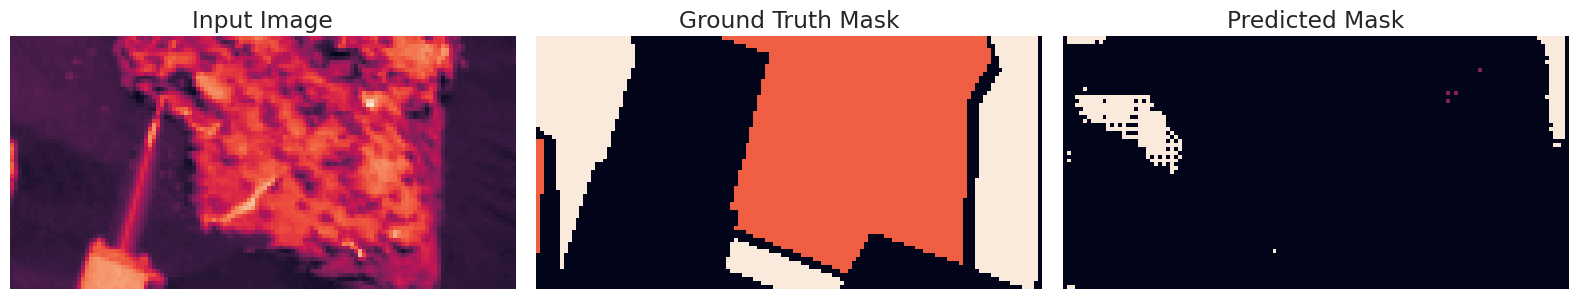

126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - accuracy: 0.7327 - loss: 0.7642 - mean_iou: 0.4350 - val_accuracy: 0.6340 - val_loss: 0.9870 - val_mean_iou: 0.3318
Epoch 32/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.7329 - loss: 0.7497 - mean_iou: 0.4343 - val_accuracy: 0.6293 - val_loss: 0.9888 - val_mean_iou: 0.3434
Epoch 33/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.7386 - loss: 0.7390 - mean_iou: 0.4412 - val_accuracy: 0.4474 - val_loss: 1.2800 - val_mean_iou: 0.1684
Epoch 34/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.7379 - loss: 0.7247 - mean_iou: 0.4395 - val_accuracy: 0.5047 - val_loss: 1.2963 - val_mean_iou: 0.2281
Epoch 35/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.7396 - loss: 0.7122 - mean_iou: 0.4420 - val_accuracy: 0.6648 - val_loss: 0.9330 - val_mean_iou: 0.3886
Epoch 36/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.7409 - loss: 0.6933 - mean_iou: 0.4434 - val_accuracy: 0.5971 - val

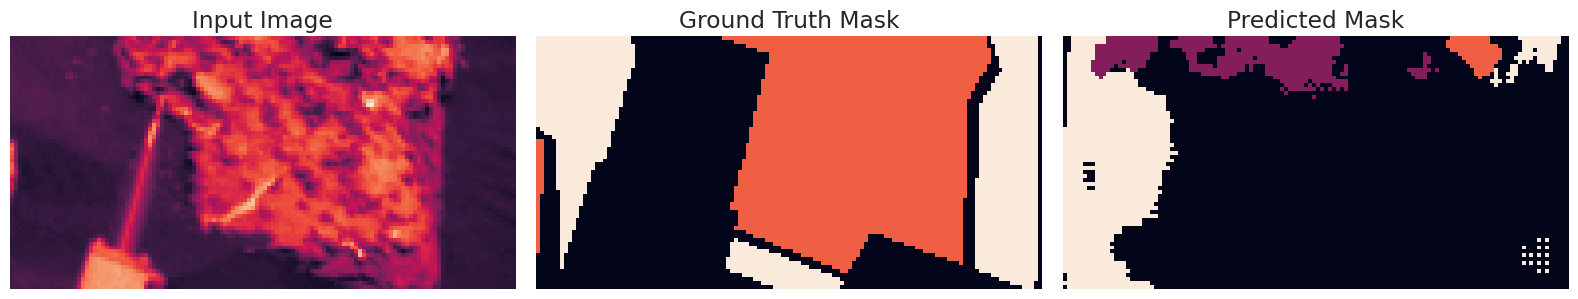

126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - accuracy: 0.7509 - loss: 0.6459 - mean_iou: 0.4498 - val_accuracy: 0.6192 - val_loss: 0.9831 - val_mean_iou: 0.3144
Epoch 42/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.7599 - loss: 0.6364 - mean_iou: 0.4593 - val_accuracy: 0.6947 - val_loss: 0.8418 - val_mean_iou: 0.4052
Epoch 43/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.7558 - loss: 0.6319 - mean_iou: 0.4571 - val_accuracy: 0.6342 - val_loss: 0.9780 - val_mean_iou: 0.3262
Epoch 44/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.7571 - loss: 0.6303 - mean_iou: 0.4575 - val_accuracy: 0.6165 - val_loss: 1.0184 - val_mean_iou: 0.3383
Epoch 45/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.7672 - loss: 0.6112 - mean_iou: 0.4648 - val_accuracy: 0.5406 - val_loss: 1.3210 - val_mean_iou: 0.2577
Epoch 46/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.7405 - loss: 0.6845 - mean_iou: 0.4436 - val_accuracy: 0.5492 - val

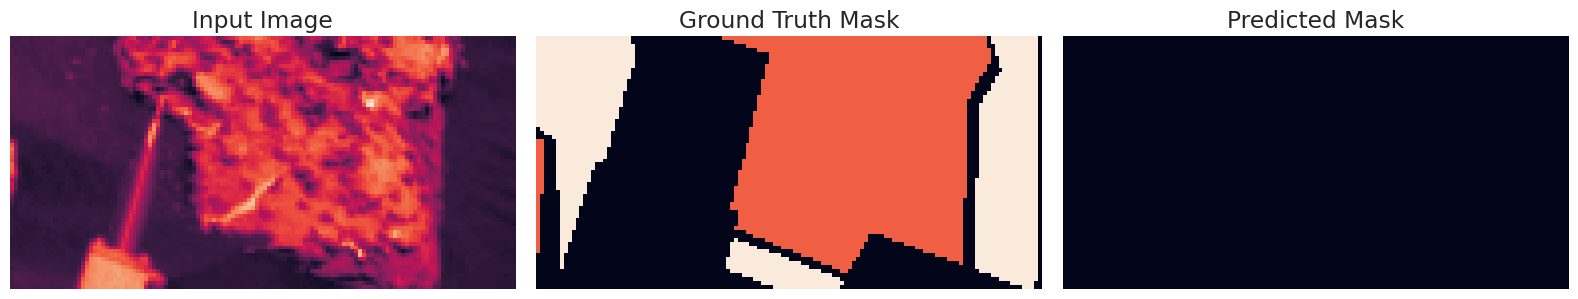

126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 250ms/step - accuracy: 0.7843 - loss: 0.5601 - mean_iou: 0.4767 - val_accuracy: 0.6057 - val_loss: 1.0048 - val_mean_iou: 0.3189
Epoch 52/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.7887 - loss: 0.5411 - mean_iou: 0.4800 - val_accuracy: 0.7021 - val_loss: 0.8072 - val_mean_iou: 0.4085
Epoch 53/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.8033 - loss: 0.5062 - mean_iou: 0.4865 - val_accuracy: 0.6935 - val_loss: 0.8176 - val_mean_iou: 0.3894
Epoch 54/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.8069 - loss: 0.4954 - mean_iou: 0.4887 - val_accuracy: 0.6323 - val_loss: 1.0052 - val_mean_iou: 0.3691
Epoch 55/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.7696 - loss: 0.5843 - mean_iou: 0.4624 - val_accuracy: 0.6739 - val_loss: 0.8661 - val_mean_iou: 0.3721
Epoch 56/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.8119 - loss: 0.4869 - mean_iou: 0.4917 - val_accuracy: 0.6930 - val

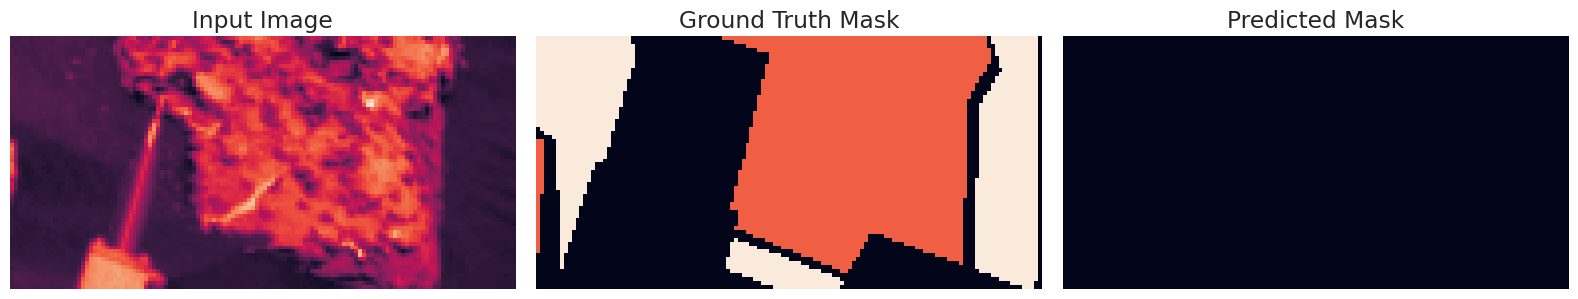

126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 250ms/step - accuracy: 0.8100 - loss: 0.4836 - mean_iou: 0.4926 - val_accuracy: 0.6328 - val_loss: 1.0264 - val_mean_iou: 0.3499
Epoch 62/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.8272 - loss: 0.4501 - mean_iou: 0.5013 - val_accuracy: 0.5467 - val_loss: 1.3499 - val_mean_iou: 0.2749
Epoch 63/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.8121 - loss: 0.4810 - mean_iou: 0.4907 - val_accuracy: 0.5921 - val_loss: 1.1976 - val_mean_iou: 0.3096
Epoch 64/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.8094 - loss: 0.4922 - mean_iou: 0.4914 - val_accuracy: 0.6635 - val_loss: 0.9370 - val_mean_iou: 0.3679
Epoch 65/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.8423 - loss: 0.4087 - mean_iou: 0.5110 - val_accuracy: 0.6542 - val_loss: 0.9107 - val_mean_iou: 0.3858
Epoch 66/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.8498 - loss: 0.3899 - mean_iou: 0.5153 - val_accuracy: 0.6337 - val

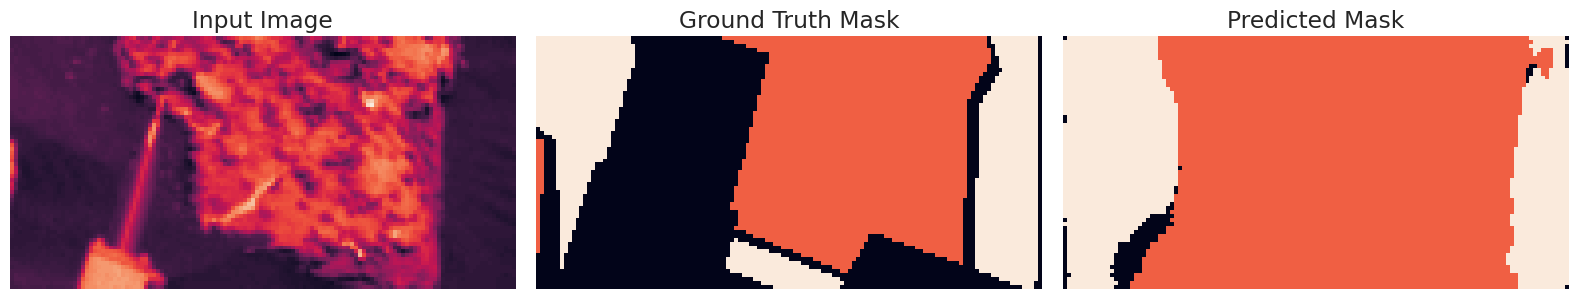

126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - accuracy: 0.8659 - loss: 0.3497 - mean_iou: 0.5259 - val_accuracy: 0.5545 - val_loss: 1.3152 - val_mean_iou: 0.2996
Epoch 72/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.8755 - loss: 0.3237 - mean_iou: 0.5322 - val_accuracy: 0.5199 - val_loss: 1.2317 - val_mean_iou: 0.2849
Epoch 73/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.8807 - loss: 0.3118 - mean_iou: 0.5336 - val_accuracy: 0.6440 - val_loss: 1.0321 - val_mean_iou: 0.4048
Epoch 74/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.8859 - loss: 0.3032 - mean_iou: 0.5395 - val_accuracy: 0.5990 - val_loss: 1.0158 - val_mean_iou: 0.3599
Epoch 75/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.8933 - loss: 0.2806 - mean_iou: 0.5453 - val_accuracy: 0.6125 - val_loss: 1.0172 - val_mean_iou: 0.3730
Epoch 76/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.8966 - loss: 0.2746 - mean_iou: 0.5468 - val_accuracy: 0.6442 - val

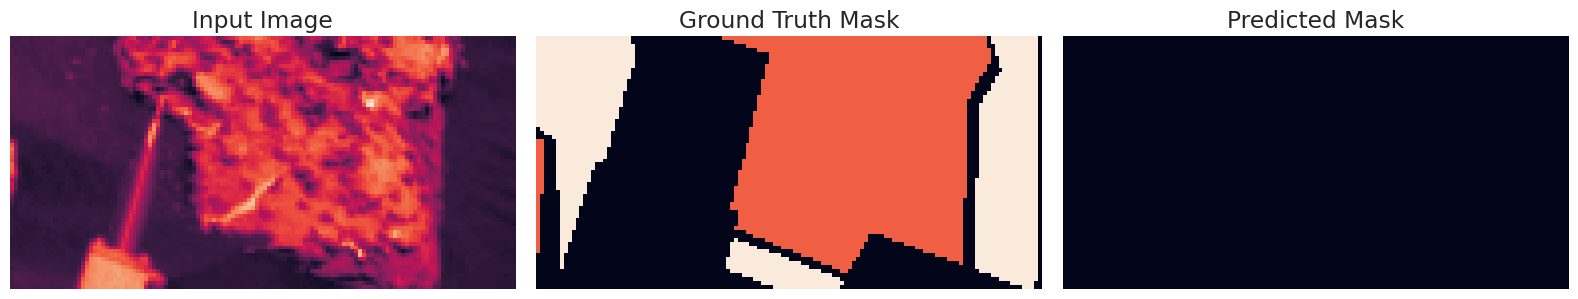

126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - accuracy: 0.9048 - loss: 0.2520 - mean_iou: 0.5540 - val_accuracy: 0.5178 - val_loss: 1.3052 - val_mean_iou: 0.2469
Epoch 82/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9085 - loss: 0.2436 - mean_iou: 0.5573 - val_accuracy: 0.6222 - val_loss: 1.1284 - val_mean_iou: 0.3349
Epoch 83/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9073 - loss: 0.2456 - mean_iou: 0.5627 - val_accuracy: 0.5346 - val_loss: 1.2737 - val_mean_iou: 0.2749
Epoch 84/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9100 - loss: 0.2381 - mean_iou: 0.5665 - val_accuracy: 0.5857 - val_loss: 1.1256 - val_mean_iou: 0.2896
Epoch 85/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9148 - loss: 0.2288 - mean_iou: 0.5704 - val_accuracy: 0.4863 - val_loss: 1.6498 - val_mean_iou: 0.2090
Epoch 86/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9155 - loss: 0.2259 - mean_iou: 0.5736 - val_accuracy: 0.5536 - val

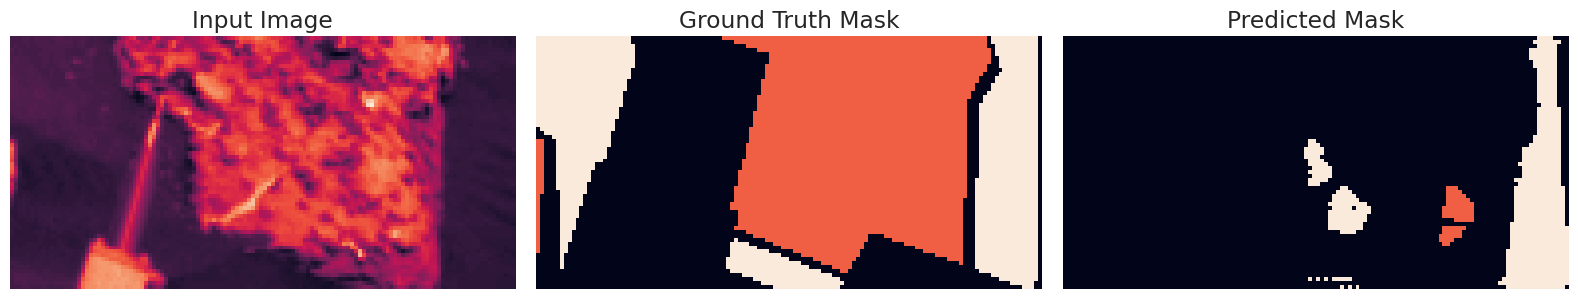

126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - accuracy: 0.9264 - loss: 0.1956 - mean_iou: 0.5769 - val_accuracy: 0.5795 - val_loss: 1.3343 - val_mean_iou: 0.2888
Epoch 92/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.9281 - loss: 0.1923 - mean_iou: 0.5815 - val_accuracy: 0.5764 - val_loss: 1.2869 - val_mean_iou: 0.2958
Epoch 93/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.9322 - loss: 0.1808 - mean_iou: 0.5785 - val_accuracy: 0.5885 - val_loss: 1.2484 - val_mean_iou: 0.3264
Epoch 94/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.9317 - loss: 0.1846 - mean_iou: 0.5838 - val_accuracy: 0.5382 - val_loss: 1.6051 - val_mean_iou: 0.2802
Epoch 95/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9103 - loss: 0.2372 - mean_iou: 0.5688 - val_accuracy: 0.5138 - val_loss: 1.5206 - val_mean_iou: 0.2524
Epoch 96/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9217 - loss: 0.2112 - mean_iou: 0.5792 - val_accuracy: 0.5949 - val

126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 254ms/step - accuracy: 0.9403 - loss: 0.1569 - mean_iou: 0.6094 - val_accuracy: 0.5863 - val_loss: 1.2809 - val_mean_iou: 0.3397
Epoch 102/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.9423 - loss: 0.1525 - mean_iou: 0.6149 - val_accuracy: 0.5710 - val_loss: 1.3894 - val_mean_iou: 0.2971
Epoch 103/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9424 - loss: 0.1516 - mean_iou: 0.6040 - val_accuracy: 0.5229 - val_loss: 1.6924 - val_mean_iou: 0.2560
Epoch 104/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9421 - loss: 0.1531 - mean_iou: 0.6016 - val_accuracy: 0.5008 - val_loss: 1.5890 - val_mean_iou: 0.2743
Epoch 105/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.9423 - loss: 0.1532 - mean_iou: 0.6148 - val_accuracy: 0.5698 - val_loss: 1.2978 - val_mean_iou: 0.3053
Epoch 106/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.9453 - loss: 0.1444 - mean_iou: 0.6228 - val_accuracy: 0.4966 

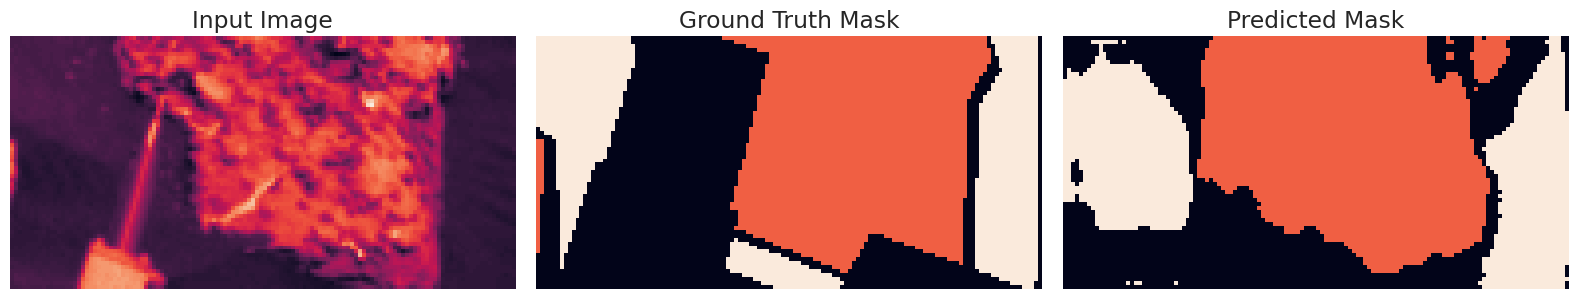

126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - accuracy: 0.9492 - loss: 0.1333 - mean_iou: 0.6268 - val_accuracy: 0.6445 - val_loss: 1.1543 - val_mean_iou: 0.3631
Epoch 112/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9505 - loss: 0.1284 - mean_iou: 0.6268 - val_accuracy: 0.5711 - val_loss: 1.3883 - val_mean_iou: 0.3024
Epoch 113/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.9524 - loss: 0.1228 - mean_iou: 0.6293 - val_accuracy: 0.5481 - val_loss: 1.4192 - val_mean_iou: 0.2892
Epoch 114/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.9515 - loss: 0.1253 - mean_iou: 0.6390 - val_accuracy: 0.6011 - val_loss: 1.4074 - val_mean_iou: 0.3206
Epoch 115/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9514 - loss: 0.1264 - mean_iou: 0.6439 - val_accuracy: 0.6448 - val_loss: 1.2068 - val_mean_iou: 0.3520
Epoch 116/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.9509 - loss: 0.1275 - mean_iou: 0.6171 - val_accuracy: 0.5961 

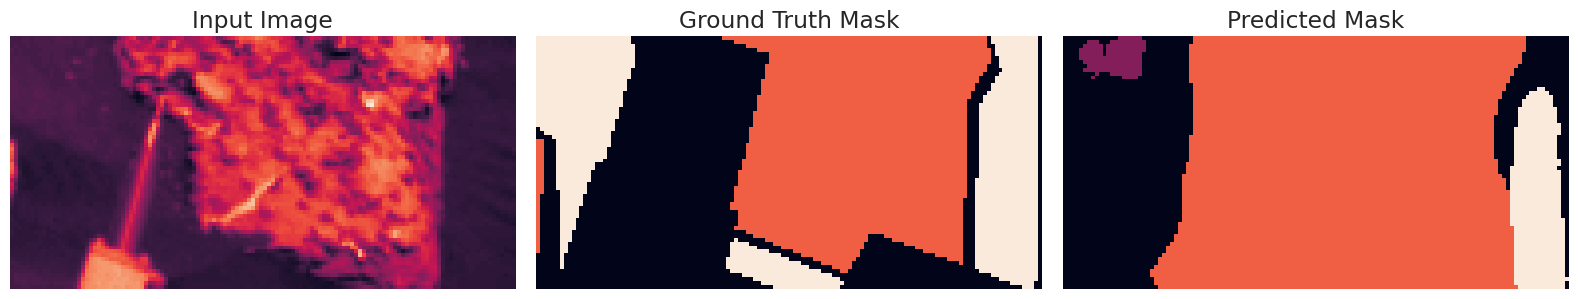

126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - accuracy: 0.9560 - loss: 0.1139 - mean_iou: 0.6253 - val_accuracy: 0.6545 - val_loss: 1.2945 - val_mean_iou: 0.3667
Epoch 122/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.9575 - loss: 0.1096 - mean_iou: 0.6364 - val_accuracy: 0.6146 - val_loss: 1.2702 - val_mean_iou: 0.3321
Epoch 123/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9579 - loss: 0.1088 - mean_iou: 0.6285 - val_accuracy: 0.6366 - val_loss: 1.2272 - val_mean_iou: 0.3378
Epoch 124/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.9488 - loss: 0.1345 - mean_iou: 0.6200 - val_accuracy: 0.5550 - val_loss: 1.6091 - val_mean_iou: 0.2764
Epoch 125/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9538 - loss: 0.1188 - mean_iou: 0.6356 - val_accuracy: 0.5974 - val_loss: 1.5109 - val_mean_iou: 0.2982
Epoch 126/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9589 - loss: 0.1053 - mean_iou: 0.6501 - val_accuracy: 0.6020 

In [70]:
# Train the model
history = model.fit(
    train_dataset_aug,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1,
    shuffle = True
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

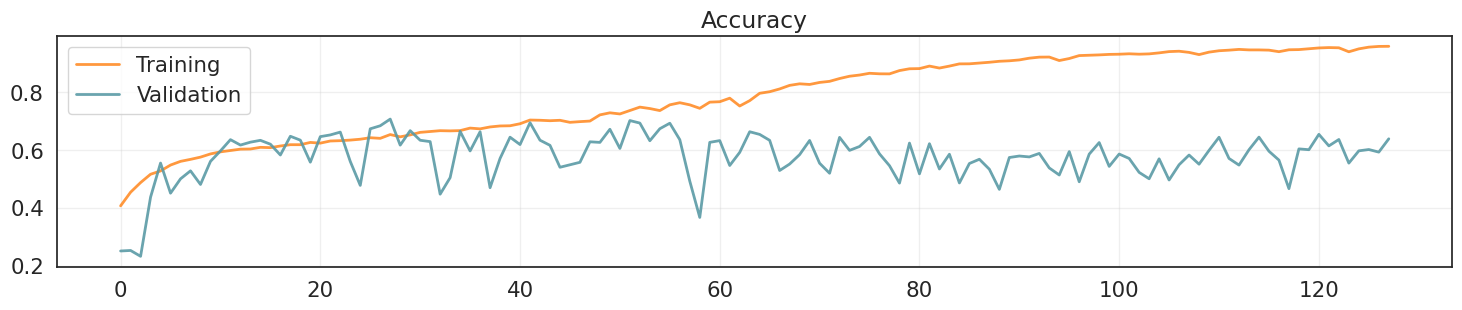

In [71]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Use the model - Make inference

In [72]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('UNet_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [73]:
model = tfk.models.load_model(model_filename, compile=False)
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print(f"Model loaded from {model_filename}")

Model loaded from UNet_40.85.keras


In [74]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step
Predictions shape: (10022, 64, 128)


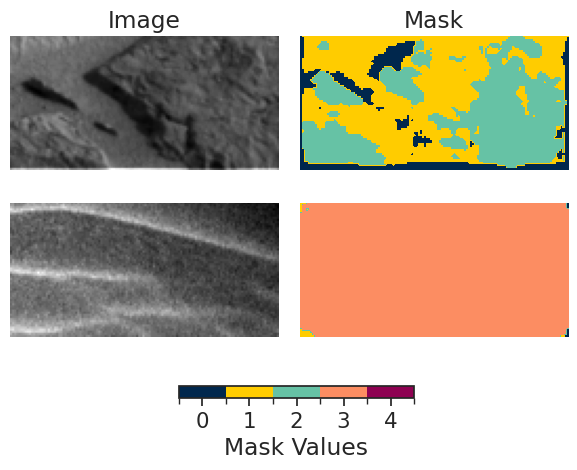

In [75]:
# Define the unique classes in the mask
classes = [0, 1, 2, 3, 4]  # Replace with the actual values in cleaned_y

# Define a custom colormap using the new colors
cmap = mcolors.ListedColormap(["#00274d", "#ffcc00", "#66c2a5", "#fc8d62", "#8e0152"])
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(classes) + 1) - 0.5, ncolors=len(classes))

plt.figure(figsize=(6, 4))

random_index1 = 0
random_index2 = 1

# Plot first image
plt.subplot(2, 2, 1)
plt.imshow(X_test[random_index1], cmap="gray")
plt.axis("off")
plt.title("Image")

plt.subplot(2, 2, 2)
im = plt.imshow(preds[random_index1], cmap=cmap, norm=norm)
plt.title("Mask")
plt.axis("off")

# Plot second image
plt.subplot(2, 2, 3)
plt.imshow(X_test[random_index2], cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(preds[random_index2], cmap=cmap, norm=norm)
plt.axis("off")

# Adjust layout to make room for the colorbar
plt.subplots_adjust(bottom=-0.1)  # Adjust to move colorbar lower

# Add colorbar with smaller size
cbar = plt.colorbar(im, ax=plt.gcf().axes, orientation='horizontal', fraction=0.03, pad=0.1)
cbar.set_ticks(classes)
cbar.set_label("Mask Values")

# Display the images
plt.tight_layout()
plt.show()


In [76]:
import pandas as pd
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [77]:
# Create and download the csv submission file
timestep_str = model_filename.replace("UNet_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

In [78]:
del model